In [16]:
import pandas as pd
import matplotlib.pyplot as plt

data_df = pd.read_csv("finalalldata.csv")

data_df.shape

(633, 17)

In [4]:
data_df.describe()

,label,sex,age,bmi,smoke,location,rs10007052,rs8192288,rs20541,rs12922394,rs2910164,rs161976,rs473892,rs159497,rs9296092
count,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,624.000000,628.000000,629.000000,628.000000,629.000000,598.000000,633.000000,595.000000,620.000000
mean,0.696682,1.271722,63.417062,23.190724,0.631912,6.617678,1.391994,0.891881,0.804953,0.859815,1.406741,1.255722,1.299271,1.337422,1.185820
std,0.460055,0.445199,15.369700,3.661055,0.482667,1.523725,0.511025,0.188801,0.199016,0.184891,0.348731,0.387540,0.336951,0.374177,0.492045
min,0.000000,1.000000,21.000000,14.300000,0.000000,4.630000,1.000000,0.351293,0.448632,0.423280,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,1.000000,55.000000,20.730000,0.000000,5.310000,1.000000,0.592700,0.669800,0.650600,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,66.000000,23.030000,1.000000,6.880000,1.000000,1.000000,0.669800,1.000000,1.416000,1.000000,1.473000,1.445000,1.000000
75%,1.000000,2.000000,75.000000,25.240000,1.000000,7.780000,1.671000,1.000000,1.000000,1.000000,1.416000,1.594000,1.473000,1.445000,1.000000
max,1.000000,2.000000,98.000000,43.560000,1.000000,8.720000,2.792241,1.000000,1.000000,1.000000,2.005056,2.540836,2.169729,2.088025,3.356224


In [5]:
data_df.columns

Index(['uid', 'label', 'sex', 'age', 'bmi', 'smoke', 'location', 'rs10007052',
       'rs8192288', 'rs20541', 'rs12922394', 'rs2910164', 'rs161976',
       'rs473892', 'rs159497', 'rs9296092', 'class'],
      dtype='object')

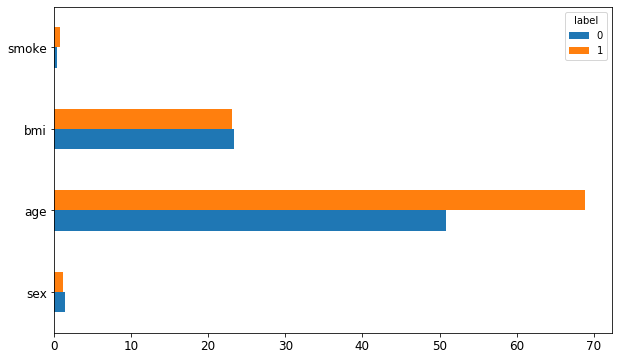

In [34]:
data_df.groupby(['label']).mean()[['sex', 'age', 'bmi', 'smoke']].transpose().plot.barh(figsize=(10,6), fontsize=12);

In [40]:
data_df['label'].value_counts()

1    441
0    192
Name: label, dtype: int64

# Model Training

First we split the data into train and test, then impute the missing values.

In [44]:
from sklearn.utils import shuffle

train_df = data_df[data_df['class'] == 'train']
test_df = data_df[data_df['class'] == 'validate']

train_df = shuffle(train_df,random_state = 42)
test_df = shuffle(test_df,random_state = 42)

In [46]:
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier 

# Define classifiers with default parameters

knn = KNeighborsClassifier()
svm = SVC(probability=True,random_state=42)
lr = LogisticRegression(random_state=42,penalty='l1',C=10,max_iter=50,intercept_scaling=10)
tree = DecisionTreeClassifier()
nn = MLPClassifier(hidden_layer_sizes=(4,4,4),random_state = 42)
xgboost = xgb.XGBClassifier(scale_pos_weight=pos_weight,random_state=42,learning_rate=0.05,n_estimators=5000,max_depth = 500,reg_alpha=0.25,subsample=1,eval_metric="auc")

classifier_lst = [knn, lr, svm, tree, nn,xgboost]
classifier_lst_name = ['KNN', 'LR', 'SVM', 'DT', 'MLP','XGboost']

In [68]:
def fillna_data(data):
    for col in range(2,len(data.columns)-1):
        data[data.columns[col]].fillna(data[data.columns[col]].mean(),inplace = True)
    return data

In [62]:
def load_data(data):
    
    """
    Clean data, then extract the features and target from a dataframe
    """
    data = fillna_data(data)
    feature = data[['sex', 'age',"smoke", 'bmi', 'location', 'rs10007052', 'rs8192288', 'rs20541', 'rs12922394', 'rs2910164', 'rs161976', 'rs473892', 'rs159497', 'rs9296092']]
    target =  data['label']
    
    return feature,target

In [66]:
from sklearn.metrics import confusion_matrix,matthews_corrcoef,accuracy_score,\
                            f1_score,recall_score,precision_score,roc_auc_score,roc_curve,auc

def make_baseline(train_df, test_df ,classifier):
    
    """
    Collect the performance of a classifier using various measures
    """
    
    X_train,y_train = load_data(train_df)
    X_test,y_test = load_data(test_df)
    
    classifier.fit(X_train,y_train)
    pred_proba = classifier.predict_proba(X_test)
    pred = classifier.predict(X_test)
    
    acc = accuracy_score(y_test,pred)
    precisions = precision_score(y_test,pred)
    recalls = recall_score(y_test,pred)
    f1s = f1_score(y_test,pred)
    mcc = matthews_corrcoef(y_test,pred)
    
    aucs1 = roc_auc_score(y_test,pred)
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
    aucs = auc(fpr, tpr)

    return acc, precisions, recalls, f1s, aucs, mcc

In [71]:
# train models

precisions_mean_lst =[]
recalls_mean_lst =[]
f1s_mean_lst,auc_mean_lst,acc_mean_lst = [],[],[]
mcc_mean_lst =[]

for i in classifier_lst:
    acc, precisions, recalls, f1s, aucs, mcc = make_baseline(train_df, test_df, i)
    
    acc_mean_lst.append(acc)
    precisions_mean_lst.append(precisions)
    recalls_mean_lst.append(recalls)
    f1s_mean_lst.append(f1s)
    auc_mean_lst.append(aucs)
    
    mcc_mean_lst.append(mcc)

all_para = {"accuracy":acc_mean_lst,"precision":precisions_mean_lst,
            "recall":recalls_mean_lst,"f1score":f1s_mean_lst,
            "mcc_score":mcc_mean_lst,"aucscore":auc_mean_lst}
result = pd.DataFrame(all_para,index = ['KNN', 'LR', 'SVM', 'DT', 'MLP','XGboost'])
print(result)

/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


         accuracy  precision    recall   f1score  mcc_score  aucscore
KNN      0.812500   0.815476  0.907285  0.858934   0.589184  0.808319
LR       0.808333   0.796610  0.933775  0.859756   0.581049  0.823722
SVM      0.783333   0.770492  0.933775  0.844311   0.524246  0.776323
DT       0.770833   0.758065  0.933775  0.836795   0.495260  0.714078
MLP      0.770833   0.733010  1.000000  0.845938   0.529175  0.787931
XGboost  0.795833   0.768421  0.966887  0.856305   0.561990  0.852370


In [74]:
from scipy import interp
import numpy as np
import warnings
warnings.filterwarnings("ignore")

def plot_ROC(model,model_name,color):
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    probas_ = model.fit(X, y).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color=color,
             label=r'{} ROC validate (AUC = %0.2f)'.format(model_name) % (mean_auc),
             lw=2, alpha=.8)


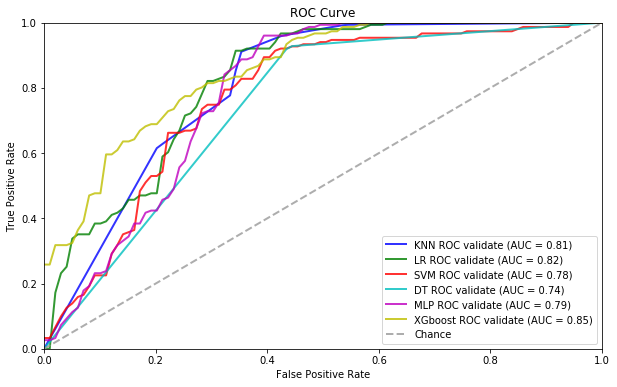

In [76]:
feature,target = load_data(train_df)
X ,y = np.array(feature),np.array(target)

X_test, y_test = load_data(test_df)
X_test, y_test = np.array(X_test),np.array(y_test)

color_list = ['b','g','r','c','m','y']
fig=plt.gcf()
fig.set_size_inches(10,6)
for model,model_name,color in zip(classifier_lst,classifier_lst_name,color_list):
    plot_ROC(model,model_name,color)
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color=(0.6, 0.6, 0.6),label='Chance', alpha=.8)
plt.xlim([-0.0, 1.0])
plt.ylim([-0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
fig.show()

# Feature Importance

weight: 
 {'age': 847, 'location': 759, 'bmi': 1612, 'sex': 213, 'rs12922394': 307, 'rs2910164': 195, 'smoke': 164, 'rs161976': 327, 'rs20541': 255, 'rs10007052': 280, 'rs473892': 255, 'rs8192288': 255, 'rs159497': 239, 'rs9296092': 92} 

gain: 
 {'age': 1.1188347881161305, 'location': 1.515597179103341, 'bmi': 0.12316694291935652, 'sex': 0.2866356711295308, 'rs12922394': 0.2980007002901766, 'rs2910164': 0.09649947845457421, 'smoke': 0.3509860842393136, 'rs161976': 0.12844815554618044, 'rs20541': 0.12135247488304776, 'rs10007052': 0.2107853249254075, 'rs473892': 0.21462315159054043, 'rs8192288': 0.125013490124664, 'rs159497': 0.08966746212963177, 'rs9296092': 0.2775427597369567} 

cover: 
 {'age': 8.373865293046036, 'location': 9.903140434848492, 'bmi': 5.858199324472717, 'sex': 4.396026395258215, 'rs12922394': 5.418236385081429, 'rs2910164': 5.027153950871792, 'smoke': 5.863843918170731, 'rs161976': 4.034979115382263, 'rs20541': 5.453507835019608, 'rs10007052': 8.803598388249997, 'rs4

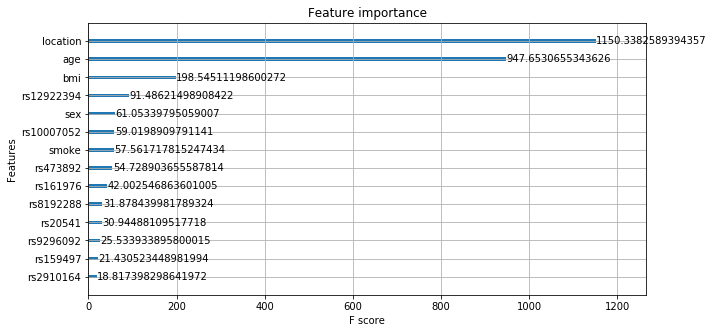

In [77]:
from xgboost import plot_importance

model = xgboost

train_x,train_y = load_data(train_df)

model.fit(train_x,train_y)

fig = plot_importance(model,importance_type="total_gain",show_values=True).get_figure()

fig.set_size_inches(10,5)
fig.show()

for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: \n' % importance_type, model.get_booster().get_score(importance_type=importance_type),"\n")